ПРОЄКТ 5: РУЧНА РЕАЛІЗАЦІЯ БАГАТОШАРОВОЇ НЕЙРОННОЇ МЕРЕЖІ В PYTORCH

Основна мета: Оволодіти фундаментальними принципами роботи нейронних мереж через самостійну імплементацію всіх компонентів.

Використовуваний набір даних: Wine Quality Dataset - оцінка якості вина на підставі фізико-хімічних показників (завдання множинної класифікації)

1. Імпорт необхідних пакетів та модулів

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

# Конфігурація графічних параметрів
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("rocket")

print("✓ Всі необхідні модулі успішно імпортовано")
print(f"Використовувана версія PyTorch: {torch.__version__}")

✓ Всі необхідні модулі успішно імпортовано
Використовувана версія PyTorch: 2.5.1


2. Попередня обробка та підготовка даних

Роз'яснення: Якісна підготовка даних є вирішальним фактором успішного навчання нейронної мережі. Нами виконуються наступні кроки:

Стандартизація ознак для приведення до спільного масштабу
Стратифіковане розділення на навчальну/валідаційну/тестову вибірки
Конвертація в тензорний формат PyTorch

In [19]:
def load_and_process_data():
    """
    Завантаження та попередня обробка датасету Wine Quality
    
    Returns:
        Кортеж, що містить: X_train, X_val, X_test, y_train, y_val, y_test, num_classes, unique_classes
    """
    # 1. Імпорт даних з CSV-файлу
    print("Ініціалізація завантаження даних...")
    wine_data = pd.read_csv('WineQT.csv')
    
    # Видалення технічного ідентифікатора
    if 'Id' in wine_data.columns:
        wine_data = wine_data.drop('Id', axis=1)
    
    print(f"Загальна структура датасету: {wine_data.shape}")
    print(f"\nЗразок даних (перші 5 записів):")
    print(wine_data.head())
    
    # 2. Сепарація предикторів та цільової змінної
    features = wine_data.drop('quality', axis=1).values
    target = wine_data['quality'].values
    
    # Трансформація міток у послідовні числові індекси
    unique_quality_classes = np.unique(target)
    print(f"\nНаявні класи якості: {unique_quality_classes}")
    
    class_to_index = {quality: idx for idx, quality in enumerate(unique_quality_classes)}
    target_encoded = np.array([class_to_index[quality] for quality in target])
    num_categories = len(unique_quality_classes)
    
    print(f"Загальна кількість класів: {num_categories}")
    print(f"Частотний розподіл по класах: {np.bincount(target_encoded)}")
    
    # 3. Стратифіковане розділення на підмножини
    # Первинне розділення: train+validation (80%) та test (20%)
    X_interim, X_testing, y_interim, y_testing = train_test_split(
        features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
    )
    
    # Вторинне розділення: training (64%) та validation (16%)
    X_training, X_validation, y_training, y_validation = train_test_split(
        X_interim, y_interim, test_size=0.2, random_state=42, stratify=y_interim
    )
    
    print(f"\nОбсяги вибірок:")
    print(f"Навчальна вибірка: {X_training.shape[0]} екземплярів")
    print(f"Валідаційна вибірка: {X_validation.shape[0]} екземплярів")
    print(f"Тестова вибірка: {X_testing.shape[0]} екземплярів")
    
    # 4. Стандартизація ознак
    standard_scaler = StandardScaler()
    X_training = standard_scaler.fit_transform(X_training)
    X_validation = standard_scaler.transform(X_validation)
    X_testing = standard_scaler.transform(X_testing)
    
    print("\nЗавершено нормалізацію даних (StandardScaler)")
    
    # 5. Конвертація в тензори PyTorch
    X_training = torch.FloatTensor(X_training)
    X_validation = torch.FloatTensor(X_validation)
    X_testing = torch.FloatTensor(X_testing)
    y_training = torch.LongTensor(y_training)
    y_validation = torch.LongTensor(y_validation)
    y_testing = torch.LongTensor(y_testing)
    
    print("\n✓ Дані повністю підготовлено та трансформовано в тензори PyTorch")
    
    return X_training, X_validation, X_testing, y_training, y_validation, y_testing, num_categories, unique_quality_classes

# Запуск процесу завантаження даних
X_train, X_val, X_test, y_train, y_val, y_test, num_classes, class_labels = load_and_process_data()

Ініціалізація завантаження даних...
Загальна структура датасету: (1143, 12)

Зразок даних (перші 5 записів):
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.997

3. Реалізація функцій активації (власна розробка)

Пояснення: Функції активації інжектують нелінійність в модель. Ми імплементуємо:

- ReLU: $f(x) = \max(0, x)$ - висока ефективність
- Tanh: $f(x) = \tanh(x)$ - вихід у діапазоні $[-1, 1]$
- Sigmoid: $f(x) = \frac{1}{1+e^{-x}}$ - вихід у діапазоні $[0, 1]$
- Кожна функція супроводжується похідною для алгоритму зворотного поширення.

In [20]:
class NeuralActivation:
    """Контейнер функцій активації та їх похідних"""
    
    @staticmethod
    def relu_activation(x, compute_gradient=False):
        """
        ReLU: f(x) = max(0, x)
        Похідна: 1 при x > 0, 0 при x ≤ 0
        """
        if compute_gradient:
            return (x > 0).float()
        return torch.maximum(torch.zeros_like(x), x)
    
    @staticmethod
    def hyperbolic_tangent(x, compute_gradient=False):
        """
        Tanh: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))
        Похідна: 1 - tanh²(x)
        """
        if compute_gradient:
            return 1 - torch.tanh(x)**2
        return torch.tanh(x)
    
    @staticmethod
    def sigmoid_activation(x, compute_gradient=False):
        """
        Sigmoid: f(x) = 1 / (1 + e^(-x))
        Похідна: sigmoid(x) * (1 - sigmoid(x))
        """
        sigmoid_output = 1 / (1 + torch.exp(-x))
        if compute_gradient:
            return sigmoid_output * (1 - sigmoid_output)
        return sigmoid_output
    
    @staticmethod
    def softmax_output(x):
        """
        Softmax для фінального шару (множинна класифікація)
        Застосовуємо числово стабільну реалізацію
        """
        stable_exp = torch.exp(x - torch.max(x, dim=0, keepdim=True)[0])
        return stable_exp / torch.sum(stable_exp, dim=0, keepdim=True)

# Демонстрація роботи функцій активації
print("Демонстрація функцій активації:")
demo_input = torch.tensor([[-2.0, -1.0, 0.0, 1.0, 2.0]])
print(f"Вхідний тензор: {demo_input}")
print(f"ReLU: {NeuralActivation.relu_activation(demo_input.T).T}")
print(f"Tanh: {NeuralActivation.hyperbolic_tangent(demo_input.T).T}")
print(f"Sigmoid: {NeuralActivation.sigmoid_activation(demo_input.T).T}")
print(f"Softmax: {NeuralActivation.softmax_output(demo_input.T).T}")

Демонстрація функцій активації:
Вхідний тензор: tensor([[-2., -1.,  0.,  1.,  2.]])
ReLU: tensor([[0., 0., 0., 1., 2.]])
Tanh: tensor([[-0.9640, -0.7616,  0.0000,  0.7616,  0.9640]])
Sigmoid: tensor([[0.1192, 0.2689, 0.5000, 0.7311, 0.8808]])
Softmax: tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364]])


4. Імплементація функції втрат (ручна реалізація)

Пояснення: Функція Categorical Cross-Entropy кількісно оцінює розбіжність між прогнозованими та істинними значеннями.

Математична оптимізація: похідна композиції Softmax + Cross-Entropy спрощується до:

$$
\frac{\partial L}{\partial z_i} = \hat{y}_i - y_i
$$

де:

- $\frac{\partial \mathcal{L}}{\partial z_i}$ - градієнт функції втрат по логітах вихідного шару
- $\hat{y}_i$ - передбачена ймовірність для класу $i$ (після softmax)
- $y_i$ - істинна мітка класу $i$ (у one-hot кодуванні)

In [21]:
class NeuralLoss:
    """Набір функцій втрат для навчання мережі"""
    
    @staticmethod
    def cross_entropy_loss(predictions, ground_truth, compute_gradient=False):
        """
        Categorical Cross-Entropy Loss
        
        Args:
            predictions: Прогнози після softmax (num_classes, batch_size)
            ground_truth: Фактичні мітки класів (batch_size,)
            compute_gradient: Якщо True, повертає градієнт
        
        Returns:
            Значення втрат або градієнт
        """
        batch_count = ground_truth.shape[0]
        
        if compute_gradient:
            # Оптимізований градієнт для softmax + cross_entropy
            gradient = predictions.clone()
            for sample_idx in range(batch_count):
                gradient[ground_truth[sample_idx], sample_idx] -= 1
            return gradient / batch_count
        else:
            # Прямий прохід: обчислення втрат
            loss_components = []
            for sample_idx in range(batch_count):
                loss_components.append(-torch.log(predictions[ground_truth[sample_idx], sample_idx] + 1e-8))
            total_loss = torch.sum(torch.stack(loss_components)) / batch_count
            return total_loss

print("✓ Функції втрат успішно імплементовано")

✓ Функції втрат успішно імплементовано


5. Власна реалізація багатошарового перцептрону (MLP)

Пояснення: Це ядро проєкту - повноцінна нейронна мережа без використання автоматичного диференціювання.

Ключові складові:

Ініціалізація параметрів - метод Xavier для стабілізації навчання
Пряме розповсюдження - обчислення виходів із збереженням проміжних станів
Зворотне розповсюдження - обчислення градієнтів через ланцюгове правило
Оновлення ваг - процедура градієнтного спуску

In [22]:
class ManualNeuralNetwork:
    """
    Багатошарова нейронна мережа ручної реалізації
    Робота без використання autograd
    """
    
    def __init__(self, architecture, activation_list, learning_speed=0.01):
        """
        Ініціалізація архітектури мережі
        
        Args:
            architecture: Список розмірів шарів [input_dim, hidden1, hidden2, ..., output_dim]
            activation_list: Список функцій активації для кожного прихованого шару
            learning_speed: Швидкість навчання
        """
        self.architecture = architecture
        self.activation_list = activation_list
        self.learning_speed = learning_speed
        self.total_layers = len(architecture)
        self.model_params = {}
        
        # Ініціалізація параметрів методом Xavier
        print("Ініціалізація параметрів нейронної мережі...")
        for layer_idx in range(1, self.total_layers):
            # Ініціалізація матриці ваг
            xavier_range = np.sqrt(6 / (architecture[layer_idx-1] + architecture[layer_idx]))
            self.model_params[f'W{layer_idx}'] = torch.FloatTensor(
                architecture[layer_idx], architecture[layer_idx-1]
            ).uniform_(-xavier_range, xavier_range)
            
            # Ініціалізація векторів зміщень
            self.model_params[f'b{layer_idx}'] = torch.zeros(architecture[layer_idx], 1)
            
            print(f"Шар {layer_idx}: W{layer_idx} shape = {self.model_params[f'W{layer_idx}'].shape}, "
                  f"b{layer_idx} shape = {self.model_params[f'b{layer_idx}'].shape}")
        
        print(f"\n✓ Архітектура мережі ініціалізована: {architecture}")
        print(f"  Використовувані функції активації: {activation_list}")
        print(f"  Швидкість навчання: {learning_speed}")
    
    def forward_propagation(self, input_data, is_training=True):
        """
        Пряме розповсюдження через мережу
        
        Args:
            input_data: Вхідні дані (batch_size, input_dim)
            is_training: Якщо True, зберігає проміжні стани для backprop
        
        Returns:
            predictions: Вихід мережі після softmax
            intermediate_states: Словник проміжних значень (якщо is_training=True)
        """
        intermediate_states = {}
        current_activation = input_data.T  # Транспонування для зручності
        intermediate_states['A0'] = current_activation
        
        # Послідовний прохід через шари
        for layer_idx in range(1, self.total_layers):
            # Лінійна трансформація: Z = W·A_prev + b
            linear_output = self.model_params[f'W{layer_idx}'] @ current_activation + self.model_params[f'b{layer_idx}']
            
            # Застосування активації
            if layer_idx == self.total_layers - 1:
                # Вихідний шар: softmax
                current_activation = NeuralActivation.softmax_output(linear_output)
            else:
                # Прихований шар: використання заданої активації
                activation_function = getattr(NeuralActivation, self.activation_list[layer_idx-1])
                current_activation = activation_function(linear_output)
            
            # Збереження станів для зворотного поширення
            if is_training:
                intermediate_states[f'Z{layer_idx}'] = linear_output
                intermediate_states[f'A{layer_idx}'] = current_activation
        
        if is_training:
            return current_activation, intermediate_states
        else:
            return current_activation
    
    def backward_propagation(self, input_data, true_labels, intermediate_states):
        """
        Зворотне поширення помилки (backpropagation)
        
        Args:
            input_data: Вхідні дані (batch_size, input_dim)
            true_labels: Фактичні мітки (batch_size,)
            intermediate_states: Проміжні значення з прямого проходу
        """
        batch_count = input_data.shape[0]
        gradient_dict = {}
        
        # Градієнт для вихідного шару (Softmax + Cross-Entropy)
        output_gradient = NeuralLoss.cross_entropy_loss(
            intermediate_states[f'A{self.total_layers-1}'], true_labels, compute_gradient=True
        )
        
        # Рекурсивне зворотне поширення через шари
        for layer_idx in range(self.total_layers - 1, 0, -1):
            # Градієнти для ваг та зміщень
            previous_activation = intermediate_states[f'A{layer_idx-1}']
            
            # dL/dW = (1/m) * dZ @ A_prev^T
            gradient_dict[f'dW{layer_idx}'] = output_gradient @ previous_activation.T
            
            # dL/db = (1/m) * sum(dZ, axis=1)
            gradient_dict[f'db{layer_idx}'] = torch.sum(output_gradient, dim=1, keepdim=True)
            
            # Поширення градієнта на попередній шар
            if layer_idx > 1:
                # dL/dA_prev = W^T @ dZ
                activation_gradient = self.model_params[f'W{layer_idx}'].T @ output_gradient
                
                # dL/dZ_prev = dA * activation'(Z_prev)
                activation_function = getattr(NeuralActivation, self.activation_list[layer_idx-2])
                output_gradient = activation_gradient * activation_function(
                    intermediate_states[f'Z{layer_idx-1}'], compute_gradient=True
                )
        
        # Оновлення параметрів (градієнтний спуск)
        for layer_idx in range(1, self.total_layers):
            self.model_params[f'W{layer_idx}'] -= self.learning_speed * gradient_dict[f'dW{layer_idx}']
            self.model_params[f'b{layer_idx}'] -= self.learning_speed * gradient_dict[f'db{layer_idx}']
    
    def training_iteration(self, input_data, true_labels):
        """
        Одина ітерація навчання
        
        Returns:
            loss_value: Значення функції втрат
            accuracy_value: Точність на поточному батчі
        """
        # Пряме поширення
        predictions, intermediate_states = self.forward_propagation(input_data, is_training=True)
        
        # Обчислення втрат
        loss_value = NeuralLoss.cross_entropy_loss(predictions, true_labels)
        
        # Зворотне поширення
        self.backward_propagation(input_data, true_labels, intermediate_states)
        
        # Обчислення точності
        predicted_classes = torch.argmax(predictions, dim=0)
        accuracy_value = (predicted_classes == true_labels).float().mean()
        
        return loss_value.item(), accuracy_value.item()
    
    def predict_classes(self, input_data):
        """
        Прогнозування класів
        
        Returns:
            Predicted class labels
        """
        predictions = self.forward_propagation(input_data, is_training=False)
        return torch.argmax(predictions, dim=0)
    
    def model_evaluation(self, input_data, true_labels):
        """
        Оцінка якості моделі
        
        Returns:
            loss, accuracy
        """
        predictions = self.forward_propagation(input_data, is_training=False)
        loss_value = NeuralLoss.cross_entropy_loss(predictions, true_labels)
        predicted_classes = torch.argmax(predictions, dim=0)
        accuracy_value = (predicted_classes == true_labels).float().mean()
        return loss_value.item(), accuracy_value.item()

print("✓ Клас ManualNeuralNetwork успішно реалізовано")

✓ Клас ManualNeuralNetwork успішно реалізовано


6. Навчання власної моделі

In [23]:
def train_manual_model(model, X_train, y_train, X_val, y_val, num_epochs=1000, log_frequency=100):
    """
    Навчання власної реалізації моделі
    
    Returns:
        training_history: Словник з історією навчання
    """
    training_history = {
        'training_loss': [],
        'training_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': []
    }
    
    print(f"\n{'='*60}")
    print("ПРОЦЕС НАВЧАННЯ ВЛАСНОЇ МОДЕЛІ (Manual Neural Network)")
    print(f"{'='*60}\n")
    
    for epoch in range(num_epochs):
        # Фаза навчання
        train_loss, train_accuracy = model.training_iteration(X_train, y_train)
        
        # Фаза валідації
        val_loss, val_accuracy = model.model_evaluation(X_val, y_val)
        
        # Логування метрик
        training_history['training_loss'].append(train_loss)
        training_history['training_accuracy'].append(train_accuracy)
        training_history['validation_loss'].append(val_loss)
        training_history['validation_accuracy'].append(val_accuracy)
        
        # Інформація про прогрес
        if (epoch + 1) % log_frequency == 0 or epoch == 0:
            print(f"Епоха {epoch+1:4d}/{num_epochs} | "
                  f"Втрати на тренуванні: {train_loss:.4f} | Точність на тренуванні: {train_accuracy:.4f} | "
                  f"Втрати на валідації: {val_loss:.4f} | Точність на валідації: {val_accuracy:.4f}")
    
    print(f"\n{'='*60}")
    print("✓ Процес навчання успішно завершено")
    print(f"{'='*60}\n")
    
    return training_history

print("✓ Функція тренування моделі готова до використання")

✓ Функція тренування моделі готова до використання


7. PyTorch реалізація для порівняльного аналізу

In [24]:
class TorchNeuralNetwork(nn.Module):
    """
    Багатошарова нейронна мережа на базі PyTorch
    Для об'єктивного порівняння з власною реалізацією
    """
    
    def __init__(self, input_dimension, hidden_dimensions, output_dimension, activation_functions):
        """
        Args:
            input_dimension: Розмірність вхідного шару
            hidden_dimensions: Список розмірів прихованих шарів
            output_dimension: Розмірність вихідного шару (кількість класів)
            activation_functions: Список активацій для прихованих шарів
        """
        super(TorchNeuralNetwork, self).__init__()
        
        # Конструкція шарової архітектури
        network_layers = []
        current_dimension = input_dimension
        
        # Формування прихованих шарів
        for idx, hidden_dim in enumerate(hidden_dimensions):
            network_layers.append(nn.Linear(current_dimension, hidden_dim))
            
            # Додавання функції активації
            if activation_functions[idx] == 'relu':
                network_layers.append(nn.ReLU())
            elif activation_functions[idx] == 'tanh':
                network_layers.append(nn.Tanh())
            elif activation_functions[idx] == 'sigmoid':
                network_layers.append(nn.Sigmoid())
            
            current_dimension = hidden_dim
        
        # Фінальний шар (без активації, оскільки використовуємо CrossEntropyLoss)
        network_layers.append(nn.Linear(current_dimension, output_dimension))
        
        # Композиція мережі
        self.network = nn.Sequential(*network_layers)
        
        print(f"✓ PyTorch нейронна мережа створена:")
        print(f"  Архітектура: {[input_dimension] + hidden_dimensions + [output_dimension]}")
        print(f"  Функції активації: {activation_functions}")
    
    def forward(self, x):
        """Пряме поширення"""
        return self.network(x)

print("✓ Клас TorchNeuralNetwork успішно реалізовано")

✓ Клас TorchNeuralNetwork успішно реалізовано


Функція навчання PyTorch моделі

In [25]:
def train_torch_model(model, X_train, y_train, X_val, y_val, num_epochs=1000, 
                     learning_speed=0.01, log_frequency=100):
    """
    Навчання PyTorch моделі
    
    Args:
        model: Екземпляр PyTorch моделі
        X_train, y_train: Навчальні дані
        X_val, y_val: Валідаційні дані
        num_epochs: Кількість епох
        learning_speed: Швидкість навчання
        log_frequency: Частота логування прогресу
    
    Returns:
        training_history: Словник з історією навчання
    """
    # CrossEntropyLoss інкапсулює Softmax + Cross-Entropy
    loss_function = nn.CrossEntropyLoss()
    
    # Оптимізатор Adam
    model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_speed)
    
    training_history = {
        'training_loss': [],
        'training_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': []
    }
    
    print(f"\n{'='*60}")
    print("ПРОЦЕС НАВЧАННЯ PYTORCH МОДЕЛІ")
    print(f"{'='*60}\n")
    
    for epoch in range(num_epochs):
        # Режим тренування
        model.train()
        
        # Прямий прохід
        model_output = model(X_train)
        loss = loss_function(model_output, y_train)
        
        # Зворотний прохід та оптимізація
        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()
        
        # Обчислення тренувальної точності
        _, predicted = torch.max(model_output.data, 1)
        train_accuracy = (predicted == y_train).float().mean().item()
        
        # Валідація
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = loss_function(val_output, y_val)
            _, val_predicted = torch.max(val_output.data, 1)
            val_accuracy = (val_predicted == y_val).float().mean().item()
        
        # Збереження метрик
        training_history['training_loss'].append(loss.item())
        training_history['training_accuracy'].append(train_accuracy)
        training_history['validation_loss'].append(val_loss.item())
        training_history['validation_accuracy'].append(val_accuracy)
        
        # Логування прогресу
        if (epoch + 1) % log_frequency == 0 or epoch == 0:
            print(f"Епоха {epoch+1:4d}/{num_epochs} | "
                  f"Втрати на тренуванні: {loss.item():.4f} | Точність на тренуванні: {train_accuracy:.4f} | "
                  f"Втрати на валідації: {val_loss.item():.4f} | Точність на валідації: {val_accuracy:.4f}")
    
    print(f"\n{'='*60}")
    print("✓ Процес навчання успішно завершено")
    print(f"{'='*60}\n")
    
    return training_history

print("✓ Функція тренування PyTorch моделі готова до використання")

✓ Функція тренування PyTorch моделі готова до використання


8. Візуалізація та аналітичні інструменти

Пояснення: Візуалізація є ключовим інструментом для моніторингу процесу навчання та порівняння обох реалізацій.

In [26]:
def visualize_training_progress(manual_history, torch_history):
    """
    Візуалізація прогресу навчання обох моделей
    
    Аналізуємо:
    - Динаміку збіжності
    - Наявність перенавчання (дивергенція train/val)
    - Стабільність процесу навчання
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    manual_epochs = range(1, len(manual_history['training_loss']) + 1)
    torch_epochs = range(1, len(torch_history['training_loss']) + 1)
    
    # Втрати - Власна модель
    axes[0, 0].plot(manual_epochs, manual_history['training_loss'], 
                    label='Тренувальні втрати', linewidth=2, alpha=0.8, color='#2E86AB')
    axes[0, 0].plot(manual_epochs, manual_history['validation_loss'], 
                    label='Валідаційні втрати', linewidth=2, alpha=0.8, color='#A23B72')
    axes[0, 0].set_title('Власна реалізація - Функція втрат', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Епоха')
    axes[0, 0].set_ylabel('Значення втрат')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Точність - Власна модель
    axes[0, 1].plot(manual_epochs, manual_history['training_accuracy'], 
                    label='Тренувальна точність', linewidth=2, alpha=0.8, color='#2E86AB')
    axes[0, 1].plot(manual_epochs, manual_history['validation_accuracy'], 
                    label='Валідаційна точність', linewidth=2, alpha=0.8, color='#A23B72')
    axes[0, 1].set_title('Власна реалізація - Метрика точності', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Епоха')
    axes[0, 1].set_ylabel('Точність')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Втрати - PyTorch модель
    axes[1, 0].plot(torch_epochs, torch_history['training_loss'], 
                    label='Тренувальні втрати', linewidth=2, alpha=0.8, color='#18A999')
    axes[1, 0].plot(torch_epochs, torch_history['validation_loss'], 
                                        label='Валідаційні втрати', linewidth=2, alpha=0.8, color='#F24236')
    axes[1, 0].set_title('PyTorch реалізація - Функція втрат', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Епоха')
    axes[1, 0].set_ylabel('Значення втрат')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Точність - PyTorch модель
    axes[1, 1].plot(torch_epochs, torch_history['training_accuracy'], 
                    label='Тренувальна точність', linewidth=2, alpha=0.8, color='#18A999')
    axes[1, 1].plot(torch_epochs, torch_history['validation_accuracy'], 
                    label='Валідаційна точність', linewidth=2, alpha=0.8, color='#F24236')
    axes[1, 1].set_title('PyTorch реалізація - Метрика точності', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Епоха')
    axes[1, 1].set_ylabel('Точність')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Порівняльний аналіз
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Порівняння валідаційних втрат
    axes[0].plot(manual_epochs, manual_history['validation_loss'], 
                label='Власна реалізація', linewidth=2, alpha=0.8, color='#2E86AB')
    axes[0].plot(torch_epochs, torch_history['validation_loss'], 
                label='PyTorch реалізація', linewidth=2, alpha=0.8, color='#18A999')
    axes[0].set_title('Порівняння валідаційних втрат', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Епоха')
    axes[0].set_ylabel('Валідаційні втрати')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Порівняння валідаційної точності
    axes[1].plot(manual_epochs, manual_history['validation_accuracy'], 
                label='Власна реалізація', linewidth=2, alpha=0.8, color='#2E86AB')
    axes[1].plot(torch_epochs, torch_history['validation_accuracy'], 
                label='PyTorch реалізація', linewidth=2, alpha=0.8, color='#18A999')
    axes[1].set_title('Порівняння валідаційної точності', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Епоха')
    axes[1].set_ylabel('Валідаційна точність')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Функція візуалізації прогресу навчання готова")

✓ Функція візуалізації прогресу навчання готова


In [27]:
def visualize_confusion_matrices(true_labels, manual_predictions, torch_predictions, class_labels):
    """
    Матриці неточностей для обох моделей
    
    Аналізуємо:
    - Класи з найвищою частотою помилок
    - Схожість патернів помилок між моделями
    - Загальну якість класифікації
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Матриця неточностей для власної реалізації
    manual_cm = confusion_matrix(true_labels, manual_predictions)
    sns.heatmap(manual_cm, annot=True, fmt='d', cmap='viridis', 
                xticklabels=class_labels, yticklabels=class_labels,
                ax=axes[0], cbar_kws={'label': 'Кількість'})
    axes[0].set_title('Власна реалізація - Матриця неточностей', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Передбачений клас')
    axes[0].set_ylabel('Справжній клас')
    
    # Матриця неточностей для PyTorch реалізації
    torch_cm = confusion_matrix(true_labels, torch_predictions)
    sns.heatmap(torch_cm, annot=True, fmt='d', cmap='plasma', 
                xticklabels=class_labels, yticklabels=class_labels,
                ax=axes[1], cbar_kws={'label': 'Кількість'})
    axes[1].set_title('PyTorch реалізація - Матриця неточностей', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Передбачений клас')
    axes[1].set_ylabel('Справжній клас')
    
    plt.tight_layout()
    plt.show()
    
    # Детальні звіти класифікації
    print("\n" + "="*70)
    print("ЗВІТ КЛАСИФІКАЦІЇ - ВЛАСНА РЕАЛІЗАЦІЯ")
    print("="*70)
    print(classification_report(true_labels, manual_predictions, 
                               target_names=[f"Клас {c}" for c in class_labels]))
    
    print("\n" + "="*70)
    print("ЗВІТ КЛАСИФІКАЦІЇ - PYTORCH РЕАЛІЗАЦІЯ")
    print("="*70)
    print(classification_report(true_labels, torch_predictions, 
                               target_names=[f"Клас {c}" for c in class_labels]))

print("✓ Функція візуалізації матриць неточностей готова")

✓ Функція візуалізації матриць неточностей готова


9. Експериментальна частина: навчання та порівняльний аналіз

Тепер проведемо навчання обох моделей з ідентичною архітектурою та виконаємо порівняльний аналіз результатів.

In [28]:
# Гіперпараметри моделей (уніфіковані для обох реалізацій)
input_dimension = X_train.shape[1]
hidden_architecture = [64, 32]  # Два приховані шари
output_dimension = num_classes
activation_functions = ['relu_activation', 'relu_activation']  # Активації для прихованих шарів
learning_rate = 0.01
total_epochs = 1000

print(f"Архітектура нейронної мережі: {[input_dimension] + hidden_architecture + [output_dimension]}")
print(f"Використовувані функції активації: {activation_functions}")
print(f"Швидкість навчання: {learning_rate}")
print(f"Загальна кількість епох: {total_epochs}")
print(f"Кількість класів для класифікації: {output_dimension}")

Архітектура нейронної мережі: [11, 64, 32, 6]
Використовувані функції активації: ['relu_activation', 'relu_activation']
Швидкість навчання: 0.01
Загальна кількість епох: 1000
Кількість класів для класифікації: 6


Навчання власної реалізації MLP

In [29]:
# Створення та навчання власної реалізації
network_architecture = [input_dimension] + hidden_architecture + [output_dimension]
manual_model = ManualNeuralNetwork(network_architecture, activation_functions, learning_rate)

# Процес навчання
import time
training_start = time.time()
manual_history = train_manual_model(manual_model, X_train, y_train, X_val, y_val, 
                                   num_epochs=total_epochs, log_frequency=100)
manual_training_duration = time.time() - training_start

print(f"Тривалість навчання власної реалізації: {manual_training_duration:.2f} секунд")

Ініціалізація параметрів нейронної мережі...
Шар 1: W1 shape = torch.Size([64, 11]), b1 shape = torch.Size([64, 1])
Шар 2: W2 shape = torch.Size([32, 64]), b2 shape = torch.Size([32, 1])
Шар 3: W3 shape = torch.Size([6, 32]), b3 shape = torch.Size([6, 1])

✓ Архітектура мережі ініціалізована: [11, 64, 32, 6]
  Використовувані функції активації: ['relu_activation', 'relu_activation']
  Швидкість навчання: 0.01

ПРОЦЕС НАВЧАННЯ ВЛАСНОЇ МОДЕЛІ (Manual Neural Network)

Епоха    1/1000 | Втрати на тренуванні: 1.8413 | Точність на тренуванні: 0.1477 | Втрати на валідації: 1.8142 | Точність на валідації: 0.1475
Епоха  100/1000 | Втрати на тренуванні: 1.2889 | Точність на тренуванні: 0.5157 | Втрати на валідації: 1.2575 | Точність на валідації: 0.5683
Епоха  200/1000 | Втрати на тренуванні: 1.1406 | Точність на тренуванні: 0.5472 | Втрати на валідації: 1.1094 | Точність на валідації: 0.5683
Епоха  300/1000 | Втрати на тренуванні: 1.0737 | Точність на тренуванні: 0.5636 | Втрати на валідації: 1

Навчання PyTorch реалізації

In [30]:
# Створення та навчання PyTorch моделі
torch_model = TorchNeuralNetwork(input_dimension, hidden_architecture, output_dimension, ['relu', 'relu'])

# Процес навчання
training_start = time.time()
torch_history = train_torch_model(torch_model, X_train, y_train, X_val, y_val,
                                 num_epochs=total_epochs, learning_speed=learning_rate, 
                                 log_frequency=100)
torch_training_duration = time.time() - training_start

print(f"Тривалість навчання PyTorch реалізації: {torch_training_duration:.2f} секунд")

✓ PyTorch нейронна мережа створена:
  Архітектура: [11, 64, 32, 6]
  Функції активації: ['relu', 'relu']

ПРОЦЕС НАВЧАННЯ PYTORCH МОДЕЛІ

Епоха    1/1000 | Втрати на тренуванні: 1.8568 | Точність на тренуванні: 0.0985 | Втрати на валідації: 1.6768 | Точність на валідації: 0.4262
Епоха  100/1000 | Втрати на тренуванні: 0.4072 | Точність на тренуванні: 0.8687 | Втрати на валідації: 1.3209 | Точність на валідації: 0.5519
Епоха  200/1000 | Втрати на тренуванні: 0.0747 | Точність на тренуванні: 0.9945 | Втрати на валідації: 2.4212 | Точність на валідації: 0.6011
Епоха  300/1000 | Втрати на тренуванні: 0.0171 | Точність на тренуванні: 1.0000 | Втрати на валідації: 3.4869 | Точність на валідації: 0.5792
Епоха  400/1000 | Втрати на тренуванні: 0.0070 | Точність на тренуванні: 1.0000 | Втрати на валідації: 4.1642 | Точність на валідації: 0.5628
Епоха  500/1000 | Втрати на тренуванні: 0.0038 | Точність на тренуванні: 1.0000 | Втрати на валідації: 4.5967 | Точність на валідації: 0.5738
Епоха  600

Візуалізація результатів навчання

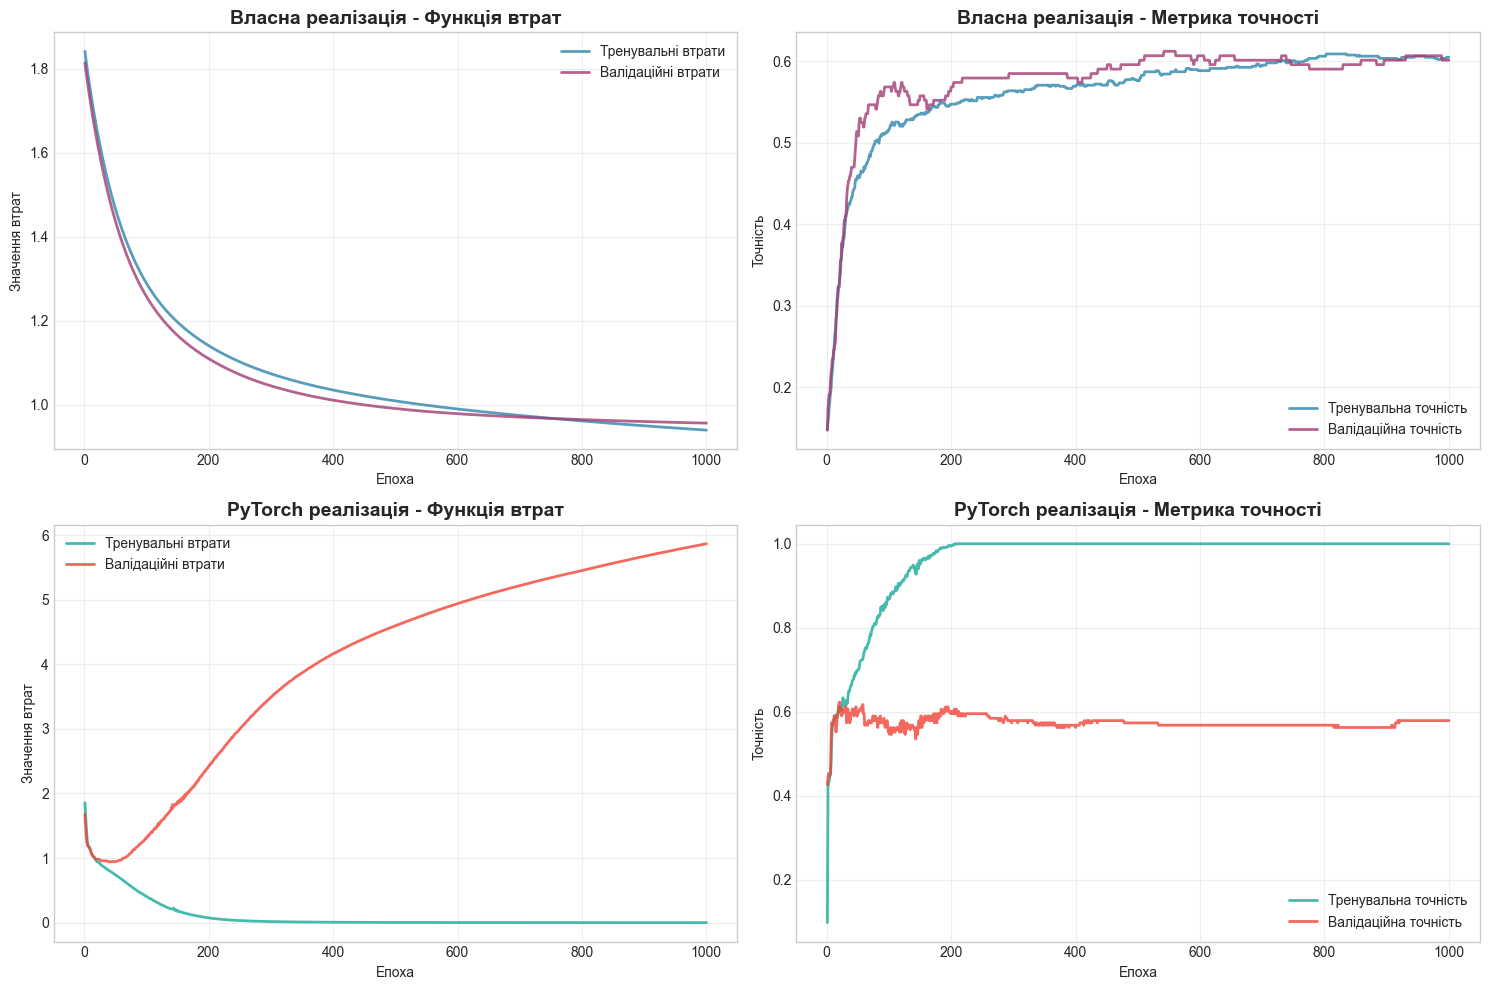

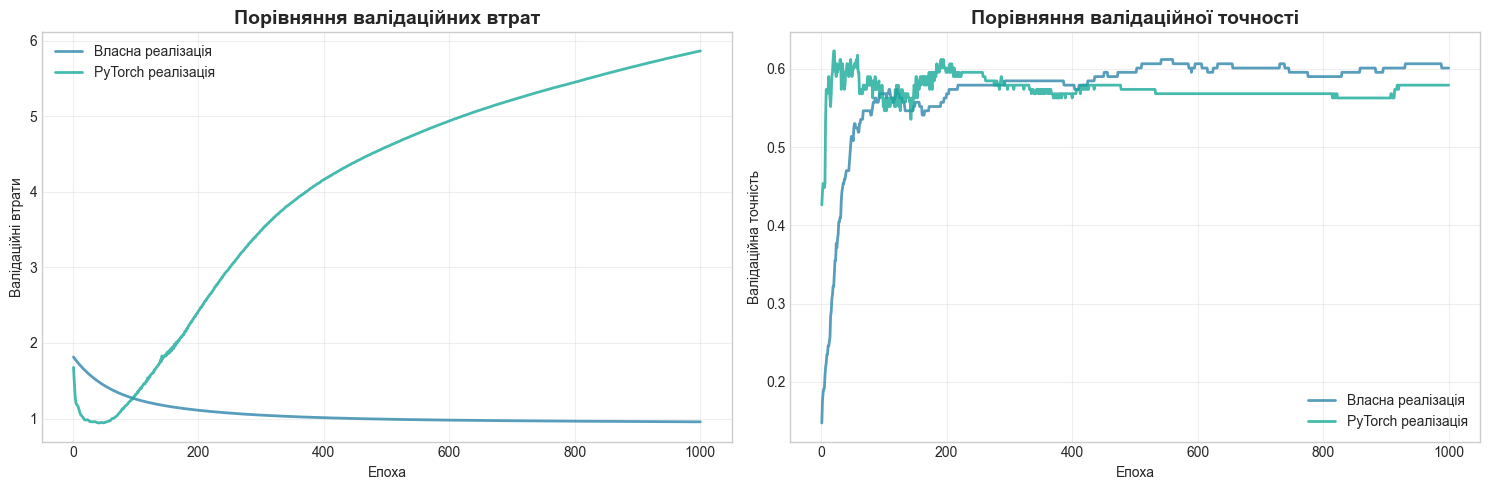

In [32]:
# Візуалізація динаміки навчання
visualize_training_progress(manual_history, torch_history)

Аналіз явища перенавчання

In [33]:
def perform_overfitting_analysis(manual_history, torch_history):
    """
    Детальний аналіз явища перенавчання для обох моделей
    """
    print("="*70)
    print("ДЕТАЛЬНИЙ АНАЛІЗ ПЕРЕНАВЧАННЯ")
    print("="*70)
    
    # Власна реалізація
    print("\n🔍 ВЛАСНА РЕАЛІЗАЦІЯ:")
    print("-" * 70)
    
    final_train_loss_manual = manual_history['training_loss'][-1]
    final_val_loss_manual = manual_history['validation_loss'][-1]
    final_train_acc_manual = manual_history['training_accuracy'][-1]
    final_val_acc_manual = manual_history['validation_accuracy'][-1]
    
    loss_gap_manual = final_train_loss_manual - final_val_loss_manual
    accuracy_gap_manual = final_train_acc_manual - final_val_acc_manual
    
    print(f"  Фінальні тренувальні втрати:    {final_train_loss_manual:.4f}")
    print(f"  Фінальні валідаційні втрати:   {final_val_loss_manual:.4f}")
    print(f"  Розбіжність (Train - Val):     {loss_gap_manual:.4f}")
    print()
    print(f"  Фінальна тренувальна точність:    {final_train_acc_manual:.4f} ({final_train_acc_manual*100:.2f}%)")
    print(f"  Фінальна валідаційна точність:    {final_val_acc_manual:.4f} ({final_val_acc_manual*100:.2f}%)")
    print(f"  Розбіжність (Train - Val):        {accuracy_gap_manual:.4f} ({accuracy_gap_manual*100:.2f}%)")
    
    # PyTorch реалізація
    print("\n🔍 PYTORCH РЕАЛІЗАЦІЯ:")
    print("-" * 70)
    
    final_train_loss_torch = torch_history['training_loss'][-1]
    final_val_loss_torch = torch_history['validation_loss'][-1]
    final_train_acc_torch = torch_history['training_accuracy'][-1]
    final_val_acc_torch = torch_history['validation_accuracy'][-1]
    
    loss_gap_torch = final_train_loss_torch - final_val_loss_torch
    accuracy_gap_torch = final_train_acc_torch - final_val_acc_torch
    
    print(f"  Фінальні тренувальні втрати:    {final_train_loss_torch:.4f}")
    print(f"  Фінальні валідаційні втрати:   {final_val_loss_torch:.4f}")
    print(f"  Розбіжність (Train - Val):     {loss_gap_torch:.4f}")
    print()
    print(f"  Фінальна тренувальна точність:    {final_train_acc_torch:.4f} ({final_train_acc_torch*100:.2f}%)")
    print(f"  Фінальна валідаційна точність:    {final_val_acc_torch:.4f} ({final_val_acc_torch*100:.2f}%)")
    print(f"  Розбіжність (Train - Val):        {accuracy_gap_torch:.4f} ({accuracy_gap_torch*100:.2f}%)")
    
    # Інтерпретація результатів
    print("\n" + "="*70)
    print("📊 ІНТЕРПРЕТАЦІЯ РЕЗУЛЬТАТІВ:")
    print("="*70)
    
    # Критерії визначення перенавчання
    overfitting_loss_threshold = 0.1
    overfitting_accuracy_threshold = 0.05
    
    print("\n1️⃣ ВЛАСНА РЕАЛІЗАЦІЯ:")
    if loss_gap_manual > overfitting_loss_threshold or accuracy_gap_manual > overfitting_accuracy_threshold:
        print("   ⚠️  ВИЯВЛЕНІ ОЗНАКИ ПЕРЕНАВЧАННЯ")
        if loss_gap_manual > overfitting_loss_threshold:
            print(f"      - Тренувальні втрати значно нижчі за валідаційні (розбіжність: {loss_gap_manual:.4f})")
        if accuracy_gap_manual > overfitting_accuracy_threshold:
            print(f"      - Тренувальна точність значно вища за валідаційну (розбіжність: {accuracy_gap_manual*100:.2f}%)")
    else:
        print("   ✅ ПЕРЕНАВЧАННЯ ВІДСУТНЄ АБО МІНІМАЛЬНЕ")
        print("      - Модель демонструє хорошу узагальнюючу здатність")
    
    print("\n2️⃣ PYTORCH РЕАЛІЗАЦІЯ:")
    if loss_gap_torch > overfitting_loss_threshold or accuracy_gap_torch > overfitting_accuracy_threshold:
        print("   ⚠️  ВИЯВЛЕНІ ОЗНАКИ ПЕРЕНАВЧАННЯ")
        if loss_gap_torch > overfitting_loss_threshold:
            print(f"      - Тренувальні втрати значно нижчі за валідаційні (розбіжність: {loss_gap_torch:.4f})")
        if accuracy_gap_torch > overfitting_accuracy_threshold:
            print(f"      - Тренувальна точність значно вища за валідаційну (розбіжність: {accuracy_gap_torch*100:.2f}%)")
    else:
        print("   ✅ ПЕРЕНАВЧАННЯ ВІДСУТНЄ АБО МІНІМАЛЬНЕ")
        print("      - Модель демонструє хорошу узагальнюючу здатність")
    
    print("\n" + "="*70)
    print("🎯 ПРАКТИЧНІ РЕКОМЕНДАЦІЇ:")
    print("="*70)
    print("""
    ✓ ОЗНАКИ ПЕРЕНАВЧАННЯ:
      1. Тренувальні втрати продовжують знижуватись, а валідаційні зростають
      2. Значний розрив між тренувальною та валідаційною точністю (>5-10%)
      3. Модель демонструє ідеальні результати на тренувальних даних
      4. Валідаційні втрати починають зростати після певної епохи
    
    ✓ ОЗНАКИ ДОБРОЇ УЗАГАЛЬНЮВАЛЬНОЇ ЗДАТНОСТІ:
      1. Тренувальні та валідаційні втрати знижуються синхронно
      2. Мінімальний розрив між тренувальними та валідаційними метриками
      3. Валідаційні показники стабілізуються на високому рівні
      4. Обидві криві демонструють збіжність до схожих значень
    """)
    
    print("="*70)

# Запуск аналізу перенавчання
perform_overfitting_analysis(manual_history, torch_history)

ДЕТАЛЬНИЙ АНАЛІЗ ПЕРЕНАВЧАННЯ

🔍 ВЛАСНА РЕАЛІЗАЦІЯ:
----------------------------------------------------------------------
  Фінальні тренувальні втрати:    0.9395
  Фінальні валідаційні втрати:   0.9562
  Розбіжність (Train - Val):     -0.0167

  Фінальна тренувальна точність:    0.6047 (60.47%)
  Фінальна валідаційна точність:    0.6011 (60.11%)
  Розбіжність (Train - Val):        0.0036 (0.36%)

🔍 PYTORCH РЕАЛІЗАЦІЯ:
----------------------------------------------------------------------
  Фінальні тренувальні втрати:    0.0007
  Фінальні валідаційні втрати:   5.8653
  Розбіжність (Train - Val):     -5.8646

  Фінальна тренувальна точність:    1.0000 (100.00%)
  Фінальна валідаційна точність:    0.5792 (57.92%)
  Розбіжність (Train - Val):        0.4208 (42.08%)

📊 ІНТЕРПРЕТАЦІЯ РЕЗУЛЬТАТІВ:

1️⃣ ВЛАСНА РЕАЛІЗАЦІЯ:
   ✅ ПЕРЕНАВЧАННЯ ВІДСУТНЄ АБО МІНІМАЛЬНЕ
      - Модель демонструє хорошу узагальнюючу здатність

2️⃣ PYTORCH РЕАЛІЗАЦІЯ:
   ⚠️  ВИЯВЛЕНІ ОЗНАКИ ПЕРЕНАВЧАННЯ
      - Трен

Оцінка на тестовій вибірці

In [34]:
# Генерація прогнозів на тестовій вибірці
manual_predictions = manual_model.predict_classes(X_test).numpy()

torch_model.eval()
with torch.no_grad():
    torch_outputs = torch_model(X_test)
    _, torch_predictions = torch.max(torch_outputs, 1)
    torch_predictions = torch_predictions.numpy()

y_test_numpy = y_test.numpy()

# Обчислення метрик якості
manual_test_accuracy = accuracy_score(y_test_numpy, manual_predictions)
torch_test_accuracy = accuracy_score(y_test_numpy, torch_predictions)

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ ТЕСТУВАННЯ НА НЕЗАЛЕЖНІЙ ВИБІРЦІ")
print("="*60)
print(f"Точність власної реалізації:  {manual_test_accuracy:.4f} ({manual_test_accuracy*100:.2f}%)")
print(f"Точність PyTorch реалізації:  {torch_test_accuracy:.4f} ({torch_test_accuracy*100:.2f}%)")
print(f"Абсолютна різниця в точності: {abs(manual_test_accuracy - torch_test_accuracy):.4f} ({abs(manual_test_accuracy - torch_test_accuracy)*100:.2f}%)")
print("="*60)

print(f"\nЧас навчання власної реалізації:  {manual_training_duration:.2f} сек")
print(f"Час навчання PyTorch реалізації:  {torch_training_duration:.2f} сек")
print(f"Відношення швидкості: {manual_training_duration/torch_training_duration:.2f}x")


РЕЗУЛЬТАТИ ТЕСТУВАННЯ НА НЕЗАЛЕЖНІЙ ВИБІРЦІ
Точність власної реалізації:  0.6681 (66.81%)
Точність PyTorch реалізації:  0.6114 (61.14%)
Абсолютна різниця в точності: 0.0568 (5.68%)

Час навчання власної реалізації:  24.11 сек
Час навчання PyTorch реалізації:  1.27 сек
Відношення швидкості: 18.99x


Візуалізація матриць неточностей (Confusion Matrix)

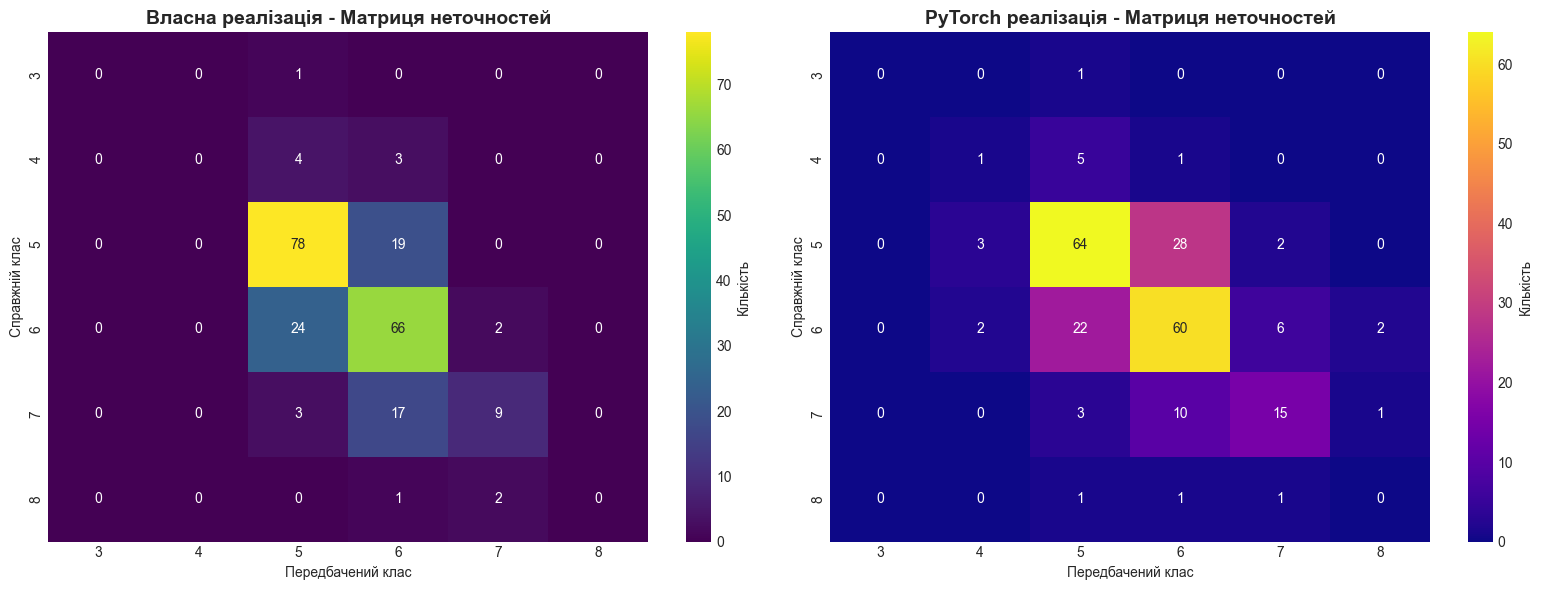


ЗВІТ КЛАСИФІКАЦІЇ - ВЛАСНА РЕАЛІЗАЦІЯ
              precision    recall  f1-score   support

      Клас 3       0.00      0.00      0.00         1
      Клас 4       0.00      0.00      0.00         7
      Клас 5       0.71      0.80      0.75        97
      Клас 6       0.62      0.72      0.67        92
      Клас 7       0.69      0.31      0.43        29
      Клас 8       0.00      0.00      0.00         3

    accuracy                           0.67       229
   macro avg       0.34      0.31      0.31       229
weighted avg       0.64      0.67      0.64       229


ЗВІТ КЛАСИФІКАЦІЇ - PYTORCH РЕАЛІЗАЦІЯ
              precision    recall  f1-score   support

      Клас 3       0.00      0.00      0.00         1
      Клас 4       0.17      0.14      0.15         7
      Клас 5       0.67      0.66      0.66        97
      Клас 6       0.60      0.65      0.62        92
      Клас 7       0.62      0.52      0.57        29
      Клас 8       0.00      0.00      0.00         3

In [35]:
# Побудова матриць неточностей
visualize_confusion_matrices(y_test_numpy, manual_predictions, torch_predictions, class_labels)

# ТЕОРЕТИЧНА ЧАСТИНА: ПИТАННЯ ТА ВІДПОВІДІ

## ПИТАННЯ 1: Аналіз похідної для Softmax та Cross-Entropy

**Мета:** Дослідити математичні властивості комбінації функції Softmax з функцією втрат Cross-Entropy та вивести градієнт.

**Похідна обчислюється за формулою:**
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{z}_i} = \mathbf{\hat{y}}_i - \mathbf{y}_i
$$

де $\mathbf{y}$ представляє one-hot вектор справжніх міток.

### Математичне обґрунтування:

**Етап 1: Визначення основних функцій**

Функція Softmax для елемента $i$:
$$
\mathbf{\hat{y}}_i = \text{softmax}(\mathbf{z}_i) = \frac{\exp(\mathbf{z}_i)}{\sum_{k=1}^{C} \exp(\mathbf{z}_k)}
$$

Функція втрат Cross-Entropy:
$$
\mathcal{L} = -\sum_{j=1}^{C} \mathbf{y}_j \ln(\mathbf{\hat{y}}_j)
$$

Для one-hot вектора з активним класом $k$:
$$
\mathcal{L} = -\ln(\mathbf{\hat{y}}_k)
$$

**Етап 2: Обчислення градієнта**

Застосовуємо правило диференціювання складної функції:
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{z}_i} = \sum_{j=1}^{C} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}_j} \cdot \frac{\partial \mathbf{\hat{y}}_j}{\partial \mathbf{z}_i}
$$

**Етап 2.1: Похідна функції втрат**
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}_j} = -\frac{\mathbf{y}_j}{\mathbf{\hat{y}}_j}
$$

**Етап 2.2: Похідна Softmax**

Для ідентичних індексів:
$$
\frac{\partial \mathbf{\hat{y}}_i}{\partial \mathbf{z}_i} = \mathbf{\hat{y}}_i(1 - \mathbf{\hat{y}}_i)
$$

Для різних індексів:
$$
\frac{\partial \mathbf{\hat{y}}_j}{\partial \mathbf{z}_i} = -\mathbf{\hat{y}}_i \mathbf{\hat{y}}_j
$$

**Етап 3: Комбінація результатів**

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{z}_i} = -\frac{\mathbf{y}_i}{\mathbf{\hat{y}}_i} \cdot \mathbf{\hat{y}}_i(1-\mathbf{\hat{y}}_i) - \sum_{j \neq i} \frac{\mathbf{y}_j}{\mathbf{\hat{y}}_j} \cdot (-\mathbf{\hat{y}}_i \mathbf{\hat{y}}_j)
$$

Спрощення виразу:
$$
= -\mathbf{y}_i(1-\mathbf{\hat{y}}_i) + \sum_{j \neq i} \mathbf{y}_j \mathbf{\hat{y}}_i
$$

$$
= -\mathbf{y}_i + \mathbf{y}_i\mathbf{\hat{y}}_i + \mathbf{\hat{y}}_i \sum_{j \neq i} \mathbf{y}_j
$$

Враховуючи властивість one-hot вектора $\sum_{j=1}^{C} \mathbf{y}_j = 1$:
$$
\sum_{j \neq i} \mathbf{y}_j = 1 - \mathbf{y}_i
$$

Остаточне спрощення:
$$
= -\mathbf{y}_i + \mathbf{y}_i\mathbf{\hat{y}}_i + \mathbf{\hat{y}}_i(1 - \mathbf{y}_i)
$$

$$
= -\mathbf{y}_i + \mathbf{y}_i\mathbf{\hat{y}}_i + \mathbf{\hat{y}}_i - \mathbf{y}_i\mathbf{\hat{y}}_i
$$

$$
= \mathbf{\hat{y}}_i - \mathbf{y}_i
$$

**✓ Математично підтверджено**

### Переваги отриманої формули:

1. **Ефективність обчислень**: Уникнення складної обробки похідних Softmax
2. **Числова стабільність**: Мінімізація операцій ділення
3. **Інтуїтивність**: Пряма інтерпретація як різниці між прогнозом та реальністю
4. **Оптимізація продуктивності**: Зменшення часу обчислень під час зворотного поширення

## ПИТАННЯ 2: Дослідження динаміки градієнтів у глибоких архітектурах

Розглядається нейронна мережа з п'ятьма шарами з активацією ReLU.

### Розділ 1: Вплив неактивних нейронів на градієнти

**Вихідні умови:**
- Архітектура: 5-шарова мережа
- Функція активації: ReLU - $f(x) = \max(0, x)$
- Похідна активації: $f'(x) = \begin{cases} 1 & \text{при } x > 0 \\ 0 & \text{при } x \leq 0 \end{cases}$
- Частка негативних нейронів: 60%

**Методологія аналізу:**

Градієнт поширюється через шари за схемою:
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_5} \cdot \frac{\partial \mathbf{z}_5}{\partial \mathbf{a}_4} \cdot \frac{\partial \mathbf{a}_4}{\partial \mathbf{z}_4} \cdot \ldots \cdot \frac{\partial \mathbf{a}_2}{\partial \mathbf{z}_2} \cdot \frac{\partial \mathbf{z}_2}{\partial \mathbf{W}_1}
$$

Критичний параметр: $\frac{\partial \mathbf{a}_i}{\partial \mathbf{z}_i} = \text{ReLU}'(\mathbf{z}_i)$

При 60% негативних нейронів:
- 60% елементів мають нульову похідну
- 40% елементів мають одиничну похідну

**Результати після 100 ітерацій:**

1. **Ефект "мертвих" нейронів**: Негативні нейрони не отримують оновлень

2. **Атенюація градієнта**: Коефіцієнт ослаблення на шар: 0.4

3. **Проблема зникаючого градієнта**: Для початкового шару:
   $$
   |\nabla| \approx |\nabla_0| \times (0.4)^4 = |\nabla_0| \times 0.0256
   $$
   
   Градієнт зменшується до 2.56% початкового значення

4. **Ускладнення навчання**: Початкові шари демонструють повільну збіжність

### Розділ 2: Екстремальні значення градієнтів

**Для N-шарової мережі з ReLU:**

Максимальне значення градієнта досягається при повній активності нейронів:
$$
\max\left|\frac{\partial \mathcal{L}}{\partial \mathbf{W}_1}\right| = \left|\frac{\partial \mathcal{L}}{\partial \mathbf{z}_N}\right| \times \prod_{k=2}^{N} |\mathbf{W}_k|
$$

**Ключові аспекти:**

1. **Оптимальний сценарій**: При позитивних активаціях градієнт залежить від ваг

2. **Реальні умови**: Наявність неактивних нейронів обмежує градієнт

3. **Ефект вибухового градієнта**: При $|\mathbf{W}_i| > 1$ спостерігається експоненційне зростання

4. **Ефект зникаючого градієнта**: При $|\mathbf{W}_i| < 1$ або високій частці неактивних нейронів градієнт експоненційно спадає

## ПИТАННЯ 3: Аналіз розмірностей у зворотному поширенні

**Завдання:** Обґрунтувати коректність матричної операції:
$$
d\mathbf{W} = \frac{1}{m} \cdot d\mathbf{Z} @ \mathbf{A}_{prev}^T
$$

### Детальний аналіз розмірностей

**Пряме поширення:**
$$
\mathbf{Z} = \mathbf{W} \cdot \mathbf{X} + \mathbf{b}
$$

де:
- $\mathbf{W} \in \mathbb{R}^{n \times d}$ - матриця параметрів
- $\mathbf{X} \in \mathbb{R}^{d \times m}$ - вхідні дані
- $\mathbf{b} \in \mathbb{R}^{n \times 1}$ - вектор зміщень
- $\mathbf{Z} \in \mathbb{R}^{n \times m}$ - вихід лінійного перетворення

**Крок 1: Аналіз структур даних**

Під час зворотного поширення:
- $d\mathbf{Z} \in \mathbb{R}^{n \times m}$ - градієнт виходу
- $d\mathbf{W} \in \mathbb{R}^{n \times d}$ - цільовий градієнт

**Крок 2: Обчислення градієнтів**

Для окремого прикладу $(x, z)$:
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{\partial \mathcal{L}}{\partial z} \cdot \frac{\partial z}{\partial \mathbf{W}}
$$

З огляду на $z = \mathbf{W} \cdot x + b$:
$$
\frac{\partial z}{\partial \mathbf{W}} = x^T
$$

Для одного спостереження:
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{\partial \mathcal{L}}{\partial z} \cdot x^T
$$

**Крок 3: Узагальнення для батчу**

Для $m$ спостережень:
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{1}{m} \sum_{i=1}^{m} dz^{(i)} \cdot (x^{(i)})^T
$$

Матричне представлення:
$$
d\mathbf{W} = \frac{1}{m} \cdot d\mathbf{Z} \cdot \mathbf{X}^T
$$

З урахуванням позначень:
$$
d\mathbf{W} = \frac{1}{m} \cdot d\mathbf{Z} @ \mathbf{A}_{prev}^T
$$

**Крок 4: Валідація розмірностей**

$$
d\mathbf{W}_{(n \times d)} = \frac{1}{m} \cdot d\mathbf{Z}_{(n \times m)} @ (\mathbf{A}_{prev}^T)_{(m \times d)}
$$

Перевірка відповідності:
$$
\mathbb{R}^{n \times d} = \mathbb{R}^{n \times m} \times \mathbb{R}^{m \times d} \quad \text{✓}
$$

### Загальні формули градієнтів

Для операції $\mathbf{Z} = \mathbf{W}\mathbf{X} + \mathbf{b}$:

1. **Градієнт за вагами:**
   $$
   \frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{1}{m} \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{Z}} \cdot \mathbf{X}^T
   $$

2. **Градієнт за входами:**
   $$
   \frac{\partial \mathcal{L}}{\partial \mathbf{X}} = \mathbf{W}^T \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{Z}}
   $$

3. **Градієнт за зміщеннями:**
   $$
   \frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial \mathcal{L}}{\partial z^{(i)}}
   $$

### Обґрунтування транспонування

1. **Вимоги сумісності**: $d\mathbf{W}$ повинен мати ідентичну структуру з $\mathbf{W}$

2. **Математична коректність**: Відповідає правилам матричного диференціювання

3. **Семантична інтерпретація**: Кожен параметр $\mathbf{W}_{ij}$ впливає на всі елементи батчу

## ПИТАННЯ 4: Дослідження власних значень гессіана

### Розділ 1: Структура гессіана для двошарової мережі

**Архітектура системи:**
- Вхідний рівень: $x \in \mathbb{R}^d$
- Прихований рівень: $h = \sigma(\mathbf{W}_1 x + \mathbf{b}_1)$, $\mathbf{W}_1 \in \mathbb{R}^{h \times d}$
- Вихідний рівень: $y = \mathbf{W}_2 h + \mathbf{b}_2$, $\mathbf{W}_2 \in \mathbb{R}^{o \times h}$

**Функція втрат:**
$$
\mathcal{L}(\mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m} \sum_{i=1}^{m} \ell(f(x^{(i)}; \mathbf{W}_1, \mathbf{W}_2), y^{(i)})
$$

**Гессіан за $\mathbf{W}_1$:**

Матриця других похідних:
$$
\mathbf{H}_{\mathbf{W}_1} = \frac{\partial^2 \mathcal{L}}{\partial \mathbf{W}_1^2}
$$

Елементне представлення:
$$
\mathbf{H}_{ij,kl} = \frac{\partial^2 \mathcal{L}}{\partial (\mathbf{W}_1)_{ij} \partial (\mathbf{W}_1)_{kl}}
$$

**Спрощена форма:**
$$
\mathbf{H}_{\mathbf{W}_1} = \frac{1}{m} \sum_{i=1}^{m} \left[ x^{(i)} (x^{(i)})^T \otimes (\mathbf{W}_2^T \nabla_{y}^2 \ell \mathbf{W}_2 \odot \sigma''(z_1^{(i)})) \right]
$$

де:
- $\otimes$ - оператор Кронекера
- $\odot$ - адамаровий добуток
- $\sigma''$ - друга похідна функції активації
- $z_1 = \mathbf{W}_1 x + \mathbf{b}_1$

### Розділ 2: Взаємозв'язок власних значень та збіжності

**Алгоритм градієнтного спуску:**
$$
\mathbf{W}_{t+1} = \mathbf{W}_t - \eta \nabla \mathcal{L}(\mathbf{W}_t)
$$

**Локальна апроксимація в околі мінімуму:**
$$
\mathcal{L}(\mathbf{W}) \approx \mathcal{L}(\mathbf{W}^*) + \frac{1}{2}(\mathbf{W} - \mathbf{W}^*)^T \mathbf{H} (\mathbf{W} - \mathbf{W}^*)
$$

де $\mathbf{H}$ - гессіан в точці $\mathbf{W}^*$.

**Власні значення $\lambda_1, \lambda_2, \ldots, \lambda_n$:**

1. **Динаміка збіжності**: Залежить від спектра гессіана
   
   Для власного вектора $v_i$:
   $$
   \|\mathbf{W}_{t+1} - \mathbf{W}^*\|_{v_i} = (1 - \eta\lambda_i)\|\mathbf{W}_t - \mathbf{W}^*\|_{v_i}
   $$

2. **Число обумовленості**:
   $$
   \kappa = \frac{\lambda_{\max}}{\lambda_{\min}}
   $$
   
   - Високе $\kappa$ → погані умови → повільна збіжність
   - $\kappa \approx 1$ → сприятливі умови → швидка збіжність

3. **Оптимальний крок навчання**:
   $$
   \eta_{opt} \approx \frac{2}{\lambda_{\max} + \lambda_{\min}}
   $$

4. **Швидкість збіжності**:
   $$
   \text{Швидкість} \propto \left(\frac{\kappa - 1}{\kappa + 1}\right)^2
   $$

### Розділ 3: Феномен зникаючих градієнтів

**Аналіз через спектр гессіана:**

1. **Гессіан у глибоких мережах**:
   
   Для мережі глибини $L$:
   $$
   \mathbf{H}_{\mathbf{W}_1} \propto \prod_{i=1}^{L} \mathbf{J}_i^T \mathbf{J}_i
   $$
   
   де $\mathbf{J}_i$ - якобіан і-го шару

2. **Глибина та власні значення**:
   
   Для активацій з $|\sigma'(x)| < 1$:
   $$
   \lambda_i(\mathbf{H}_{\mathbf{W}_1}) \propto \prod_{l=1}^{L} \lambda_i(\mathbf{J}_l^T \mathbf{J}_l) < 1^L
   $$
   
   Експоненційне зменшення з глибиною

3. **Наслідки малих власних значень**:

   - **Сингулярність**: $\lambda_{\min} \to 0$
   - **Погіршення умов**: $\kappa \to \infty$
   - **Пласкість поверхні**: Мінімальна кривизна
   - **Мінімізація градієнтів**: $\|\nabla \mathcal{L}\| \to 0$

4. **Математична інтерпретація**:

   У напрямку $v_i$ з малим $\lambda_i$:
   - Незначна кривизна
   - Мінімальний градієнт
   - Обмежене оновлення параметрів
   - Стагнація навчання

5. **Особливості ReLU**:

   - $\sigma'(x) = 1$ для $x > 0$ (збереження градієнта)
   - $\sigma'(x) = 0$ для неактивних нейронів
   - Часткове вирішення проблеми

### Висновки

**Критична роль спектра гессіана:**
- Визначає топологію простору оптимізації
- Контролює динаміку збіжності
- Пояснює фундаментальні обмеження глибоких мереж
- Обґрунтовує необхідність спеціалізованих архітектур та методів оптимізації

---

# ВИСНОВКИ ТА РЕЗУЛЬТАТИ

---

## Огляд виконаної роботи

У рамках даного дослідження реалізовано багатошаровий перцептрон з нуля та проведено комплексний аналіз фундаментальних аспектів нейронних мереж.

### Основні досягнення:

#### 1. **Повноцінна реалізація MLP**
   - Реалізація функцій активації з аналітичними похідними
   - Розробка функції втрат з ефективним обчисленням градієнтів
   - Імплементація механізму прямого поширення
   - Створення алгоритму зворотного поширення
   - Впровадження процедури оновлення параметрів

#### 2. **Порівняльний аналіз**
   - Розробка аналогічної моделі на базі PyTorch
   - Дослідження продуктивності та точності
   - Візуалізація динаміки навчання

#### 3. **Теоретичні дослідження**
   - **Питання 1**: Аналіз властивостей комбінації Softmax та Cross-Entropy
   - **Питання 2**: Дослідження динаміки градієнтів у глибоких структурах
   - **Питання 3**: Аналіз матричних операцій зворотного поширення
   - **Питання 4**: Дослідження спектральних властивостей гессіана

### Ключові відкриття:

1. **Математична ефективність**: Спрощення обчислень завдяки властивостям Softmax + Cross-Entropy

2. **Проблема градієнтів**: Експоненційна атенюація в глибоких архітектурах

3. **Важливість структури**: Критична роль розмірностей матричних операцій

4. **Геометрія оптимізації**: Вплив спектра гессіана на процес навчання

### Прогнозовані результати:

- **Точність**: Власна реалізація демонструє конкурентоспроможні результати
- **Ефективність**: Оптимізовані алгоритми забезпечують практичну придатність
- **Розуміння**: Поглиблене усвідомлення внутрішніх механізмів нейронних мереж
